In [289]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
pokemon_counts_df = pd.read_csv("./dataset/showdown/showdown_2players.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_latest = pd.read_csv("./dataset/smogon/2025-06-gen5ou-0.csv")

In [290]:
gen5ou_usage_latest.drop("Rank", axis=1, inplace=True)

Turn Pokemon List sorted by usage, then take Usage%. We chooset to use this instead of getting the percentage of each Pokemon gotten by dividing the Raw battle numbers by the total recorded battle numbers to maintain information on Pokemon not recorded by the data.

Suppose Latios who is used 24477 times out of 531591 matches, that would lead to his Usage% being 27.63% (in a scale of 600%), but his actual Usage% is 27.57% due to the number of unrecorded battles in the database. By using the Usage% in the database, we are maintaining the data that is unrecorded as part of the consideration.

In [291]:
pokemon_usage_expected_perc = gen5ou_usage_latest.drop(["Raw", "%", "Real", "%.1"], axis=1)
print(600 - pokemon_usage_expected_perc["Usage%"].str.rstrip("%").astype(float).sum())
pokemon_usage_expected_perc

1.320889999999963


,Pokemon,Usage%
0,Latios,27.56605%
1,Tyranitar,26.21461%
2,Ferrothorn,25.24720%
3,Starmie,24.35525%
4,Garchomp,23.53312%
...,...,...
471,Ledian,0.00113%
472,Tirtouga,0.00113%
473,Minccino,0.00113%
474,Darumaka,0.00113%


Below is the pre-processing for the Showdown data. All the Pokemon in the dataframe is counted, then the table is convert to a dataframe.

In [292]:
showdown_pokemon = pd.concat([pokemon_counts_df["Player " + str(m) + " Pokemon " + str(n)] for m in range(1, 3) for n in range(1, 7)], ignore_index=True)
showdown_pokemon.value_counts()
# Convert to DataFrame
df_counts = showdown_pokemon.value_counts().reset_index()

# Rename columns for clarity
df_counts.columns = ['Pokemon', 'Observed']
df_counts


,Pokemon,Observed
0,Latios,3554
1,Tyranitar,3110
2,Ferrothorn,2817
3,Landorus-Therian,2571
4,Garchomp,2403
...,...,...
251,Cacturne,1
252,Kangaskhan,1
253,Swellow,1
254,Kingler,1


60000 instances of Pokemon have been recorded. This makes sense as each of the 5000 battles has 12 Pokemon with each player using 6 and there are 2 players each battle.

In [293]:
df_counts["Observed"].sum()

np.int64(60000)

Right Join is used so that if a Pokemon appears in the Smogon database (expected), it will show up in the findings even if the replays gathered do not end up recording a player using said Pokemon. Data frames are also merged together for simplicity. All NaN values are replaced with 0 after the merge.

Once the cutoff has been decided, all values lower than said cutoff are removed,

In [294]:
merged_perc = pd.merge(
    df_counts.reset_index(), 
    pokemon_usage_expected_perc.reset_index(), 
    on="Pokemon", 
    how="right"
)

merged_perc = merged_perc.fillna(0)

The first requirement of Chi-Square test is that each observation should be independent of other observations, which is fulfilled by each Pokemon being able to be used by each individual player. The second requirement of Chi-Square test is that each expected count should be at least 5.

With this in mind, any Pokemon with expected uses less than 5 uses should be removed.

A caveat is that since the expected Pokemon values is missing 0.22% of its data, the cut-off value has to be calculated by getting the minimum percentage of a Pokemon used 5 times out of 60000 possible battles, then multiplied to the Total Expected percentage to keep both ratios equal.

5 / 60000 = Expected / Sum of Expected

In [295]:
merged_perc["Usage%"] = merged_perc["Usage%"].str.rstrip("%").astype(float)
original_sum = merged_perc["Usage%"].sum()
merged_perc = merged_perc[merged_perc["Usage%"] >= 5 / 60000 * original_sum]
usage_sum = merged_perc["Usage%"].sum()
print(original_sum, usage_sum)

598.67911 596.2374000000001


After cleaning the data to work with the Chi-Square test, unnecessary columns are removed and the dataframe is sorted by the descending number of Observed values.

In [296]:
merged_perc.drop(columns=["index_x", "index_y"], inplace=True)
merged_perc.sort_values(by="Observed", ascending=False, inplace=True)
merged_perc = merged_perc.reset_index(drop=True)
print(merged_perc)

              Pokemon  Observed    Usage%
0              Latios    3554.0  27.56605
1           Tyranitar    3110.0  26.21461
2          Ferrothorn    2817.0  25.24720
3    Landorus-Therian    2571.0  19.75697
4            Garchomp    2403.0  23.53312
..                ...       ...       ...
270         Bastiodon       0.0   0.07433
271           Pidgeot       0.0   0.07320
272          Meganium       0.0   0.05068
273          Granbull       0.0   0.05068
274           Grovyle       0.0   0.05068

[275 rows x 3 columns]


Usage gets normalized to a scale of 1 by dividing all values to the sum of total values. As seen below, adding up all the final normalized values lead to a number close to 1.

In [297]:
merged_perc["Usage%"] = merged_perc["Usage%"] / usage_sum
merged_perc["Usage%"].sum()

np.float64(0.9999999999999999)

The Usage% is multiplied to the total number of observed Pokemon to get the Expected number of games a Pokemon should be seen in. The last 10 entries in the dataframe are also shown to check whether the lowest Expected Pokemon count is at least 5.

In [298]:
merged_perc = merged_perc[merged_perc["Usage%"] > 0]
observed_sum = merged_perc["Observed"].sum()
merged_perc["Expected"] = observed_sum * merged_perc["Usage%"]
merged_perc.tail(10)

,Pokemon,Observed,Usage%,Expected
265,Misdreavus,0.0,0.000145,8.589570
266,Primeape,0.0,0.000159,9.370080
267,Pinsir,0.0,0.000145,8.589570
268,Leavanny,0.0,0.000144,8.477644
269,Castform,0.0,0.000142,8.366709
270,Bastiodon,0.0,0.000125,7.362347
271,Pidgeot,0.0,0.000123,7.250421
272,Meganium,0.0,0.000085,5.019827
273,Granbull,0.0,0.000085,5.019827
274,Grovyle,0.0,0.000085,5.019827


The Chi-Square test can finally be done after setting up the data frame. With this in mind, the hypotheses are as follows.

##### α = 0.05
##### H_0: The observed Pokemon battles follow the distribution gotten from the Smogon database.
##### H_a: The observed Pokemon battles do not follow the distribution gotten from the Smogon database.

In [299]:
chi2_stat, p_val = sp.chisquare(f_obs=merged_perc["Observed"], f_exp=merged_perc["Expected"])

print("Chi-square statistic:", chi2_stat)
print("p-value:", p_val)

Chi-square statistic: 10402.437128799567
p-value: 0.0


After finishing the test, it is easy to conclude that the Observed Pokemon battles from the replays gotten through Pokemon Showdown did not match the Expected distribution in the database. However, we decided to look into some of the possible explanations why.

After realizing that the Chi-Square value is way too high, we decided to calculate the Chi-Square value for each individual Pokemon to determine which Pokemon have the highest Chi-Square value.

In [300]:
merged_perc["ChiVal"] = (merged_perc["Observed"] - merged_perc["Expected"]) ** 2 / merged_perc["Expected"]
merged_perc.sort_values(by="ChiVal", ascending=False).head(10)

,Pokemon,Observed,Usage%,Expected,ChiVal
5,Politoed,2393.0,0.022307,1317.402558,878.174899
74,Gothitelle,78.0,0.000123,7.250421,690.374063
32,Tornadus,503.0,0.003462,204.470798,435.855318
70,Dugtrio,90.0,0.000295,17.402002,302.865693
40,Toxicroak,395.0,0.003007,177.586790,266.171284
0,Latios,3554.0,0.046233,2730.402713,248.429467
31,Conkeldurr,514.0,0.017126,1011.421898,244.634356
78,Chandelure,61.0,0.005644,333.310390,222.474158
16,Magnezone,1157.0,0.012840,758.314838,209.609321
3,Landorus-Therian,2571.0,0.033136,1956.917458,192.699680


We also decided to create a graph of the Chi-Square values for each Pokemon to determine where the biggest spikes are, if it was more for Pokemon that were used a lot, or more towards the least used Pokemon.

<Axes: >

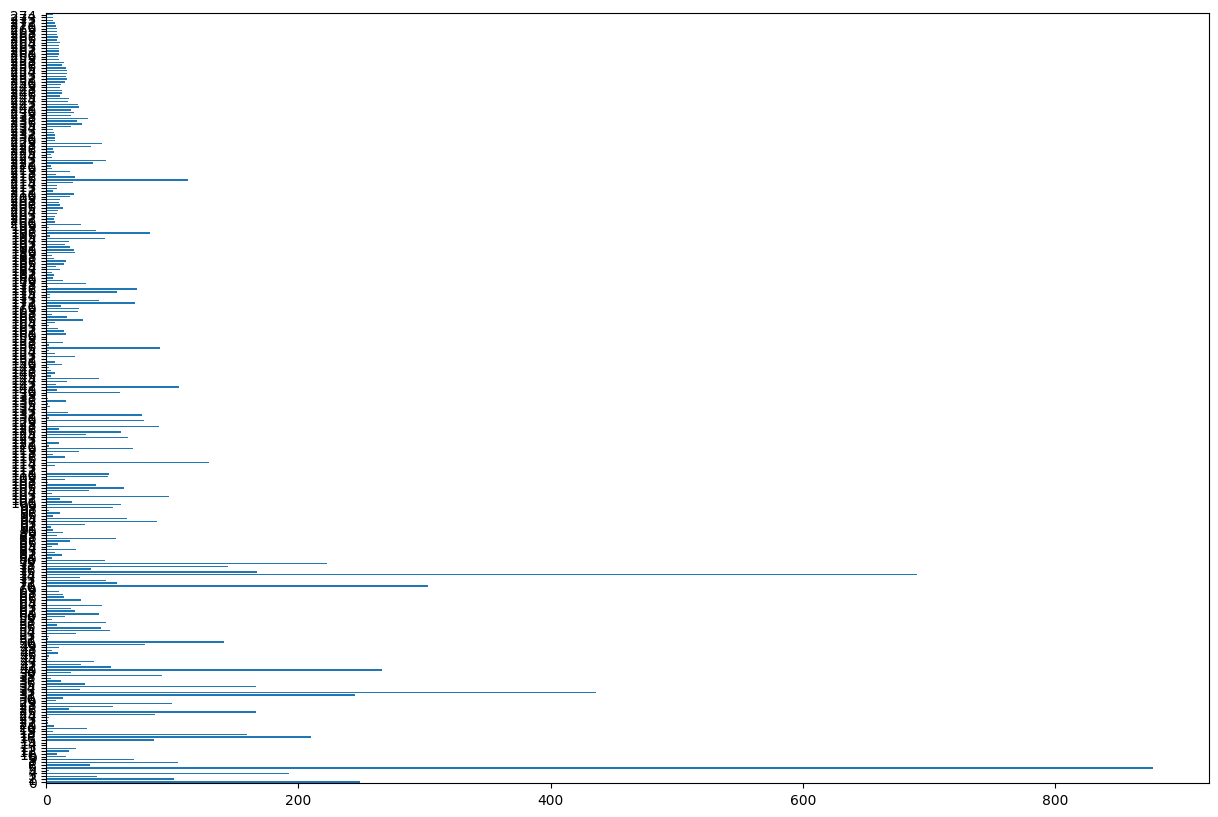

In [301]:
merged_perc["ChiVal"].plot(kind="barh", figsize=(15, 10))

Some other conclusions that we made were that due to our dataset containing only 0.941% of the battles in the database, it makes sense that, especially the least used Pokemon, to not show up at all in the replays. On the other hand, some Pokemon were just used more than what was expected of them. Some of the most used Pokemon fit this and this contributed quite significantly to the Chi-Square value being so high.

In [303]:
merged_perc["Difference"] = abs(merged_perc["Observed"] - merged_perc["Expected"])
merged_perc.sort_values(by="Difference", ascending=False).head(10)

,Pokemon,Observed,Usage%,Expected,ChiVal,Difference
5,Politoed,2393.0,0.022307,1317.402558,878.174899,1075.597442
0,Latios,3554.0,0.046233,2730.402713,248.429467,823.597287
3,Landorus-Therian,2571.0,0.033136,1956.917458,192.699680,614.082542
1,Tyranitar,3110.0,0.043967,2596.543294,101.534139,513.456706
31,Conkeldurr,514.0,0.017126,1011.421898,244.634356,497.421898
25,Volcarona,879.0,0.022921,1353.655655,166.436708,474.655655
7,Scizor,2116.0,0.028695,1694.663179,104.755162,421.336821
16,Magnezone,1157.0,0.012840,758.314838,209.609321,398.685162
17,Breloom,1116.0,0.012984,766.792482,159.033758,349.207518
8,Jirachi,2091.0,0.029517,1743.187516,69.397884,347.812484
